In [1]:
import os
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# Download data

In [2]:
import os
import zipfile
import requests

# download data
url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = "/content/jena_climate_2009_2016.csv.zip"
csv_path = "/content/jena_climate_2009_2016.csv"

# downaload zip file
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# extract zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content")

# load data
with open(csv_path, "r") as file:
    data = file.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


# Explore dataset

In [3]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


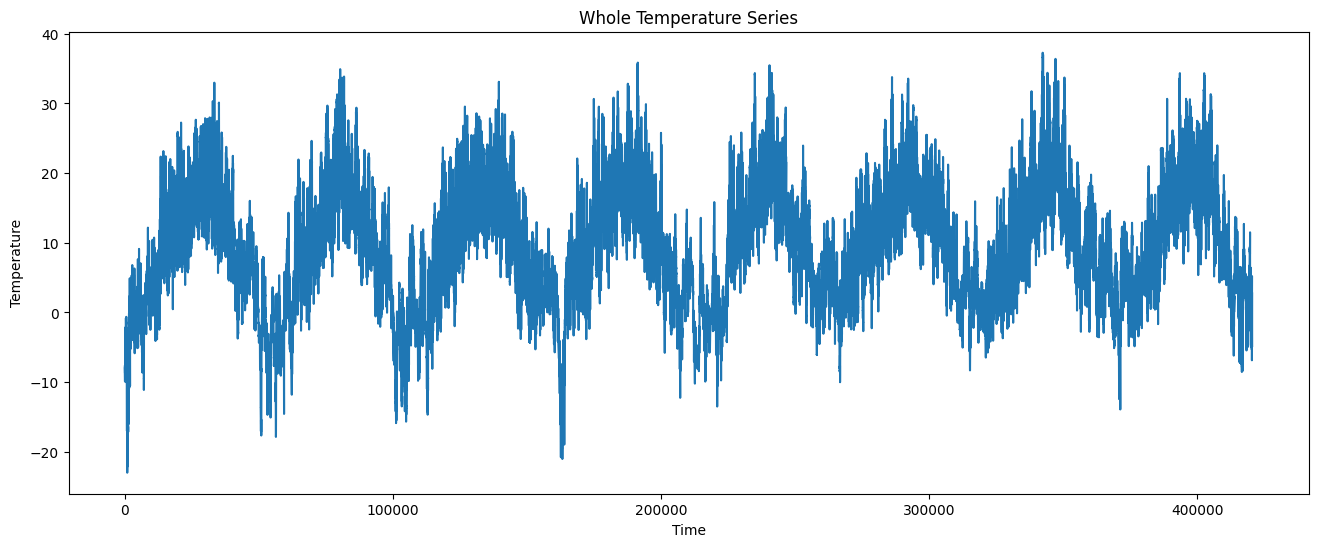

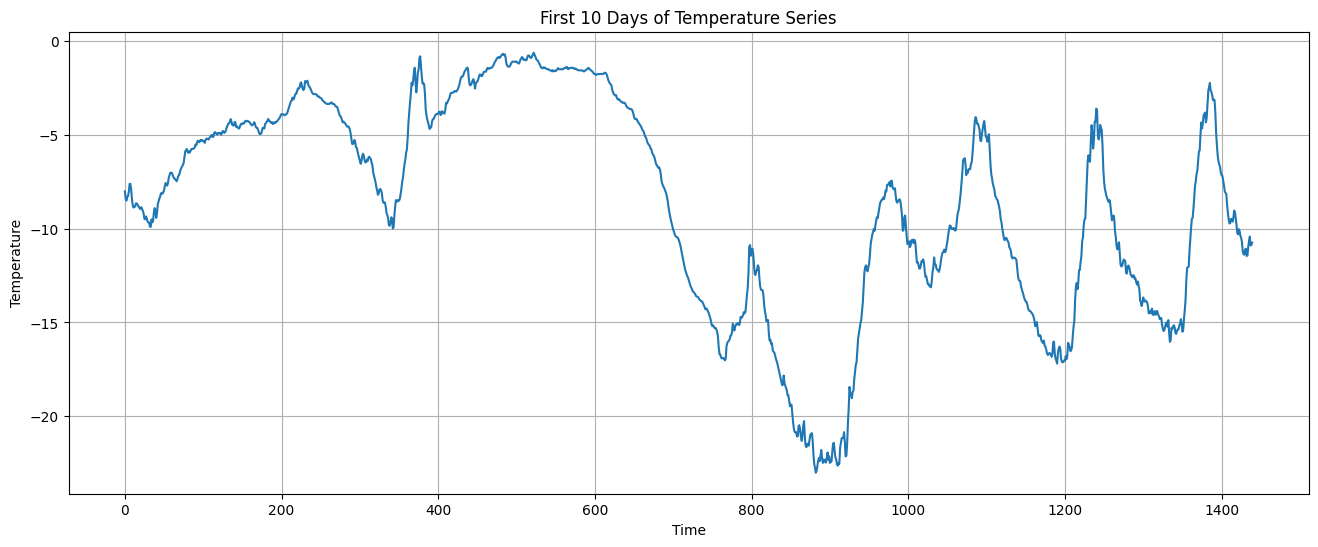

In [4]:
temp = float_data[:, 1]

# Plot whole temperature series
plt.figure(figsize=(16, 6))
plt.plot(range(len(temp)), temp)
plt.title('Whole Temperature Series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

# Plot the first few days
plt.figure(figsize=(16, 6))
plt.plot(range(10*24*6), temp[:10*24*6])
plt.title('First 10 Days of Temperature Series')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid()
plt.show()

In [5]:
# Normalize the data
float_data = (float_data - np.mean(float_data, axis=0)) / np.std(float_data[:20000, :], axis=0)

# Set up data generators

In [6]:
# generator function used to feed the training, validation and test data

def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
# Define lookback, step, delay and batch size variable
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

# Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:

val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200000,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

# Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:

test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300000,
                        max_index=400000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

# Basic approach

In [8]:
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size

In [ ]:
# Define the model
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the network for about 20 epochs
history = model.fit(train_gen,
                    #steps_per_epoch=(200000 - lookback) // batch_size,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 2.5697 - val_loss: 1.2442
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.9512 - val_loss: 0.4031
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.4072 - val_loss: 0.3024
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.2853 - val_loss: 0.3266
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2659 - val_loss: 0.3311
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.2510 - val_loss: 0.3439
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.2414 - val_loss: 0.3224
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2334 - val_loss: 0.3252
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.2293 - val_loss: 0.3213
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.2252 - val_loss: 0.3268
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.2200 - val_loss: 0.3387
Epoch 12/20
500/500 ━━━━━━━━━━━━━

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3360)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         107,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 215,172 (840.52 KB)

 Trainable params: 107,585 (420.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 107,587 (420.27 KB)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

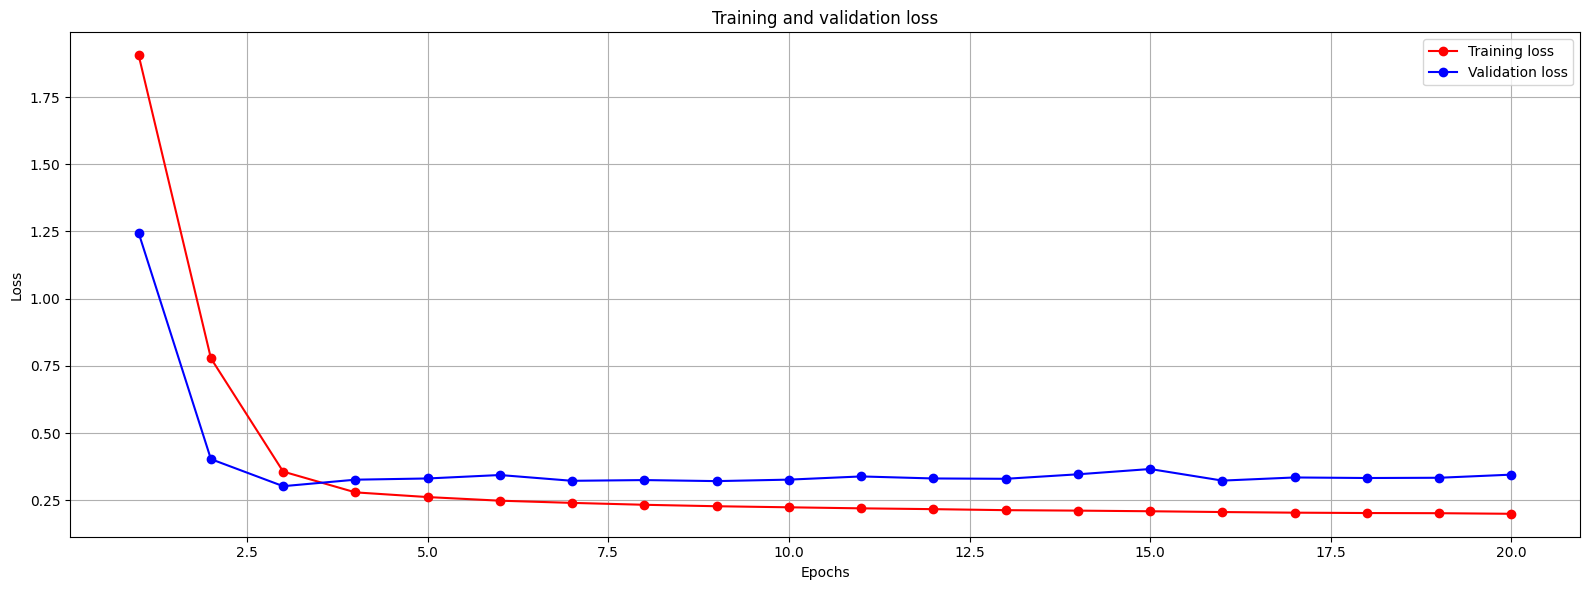

In [ ]:
# Plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 6))
plt.plot(epochs, loss, 'r-o', label='Training loss')
plt.plot(epochs, val_loss, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Gru layer

In [ ]:
# Define the GRU model
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the GRU network for about 20 epochs
history = model.fit(train_gen,
                    #steps_per_epoch=(200000 - lookback) // batch_size,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 0.3809 - val_loss: 0.2725
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.2898 - val_loss: 0.2689
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.2810 - val_loss: 0.2674
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.2778 - val_loss: 0.2625
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.2732 - val_loss: 0.2629
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.2668 - val_loss: 0.2643
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2628 - val_loss: 0.2631
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2576 - val_loss: 0.2687
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.2512 - val_loss: 0.2684
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.2485 - val_loss: 0.2712
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2439 - val_loss: 0.2770
Epoch 12/20
500/500 ━━━━━━━━━━

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284 (36.27 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,643 (18.14 KB)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

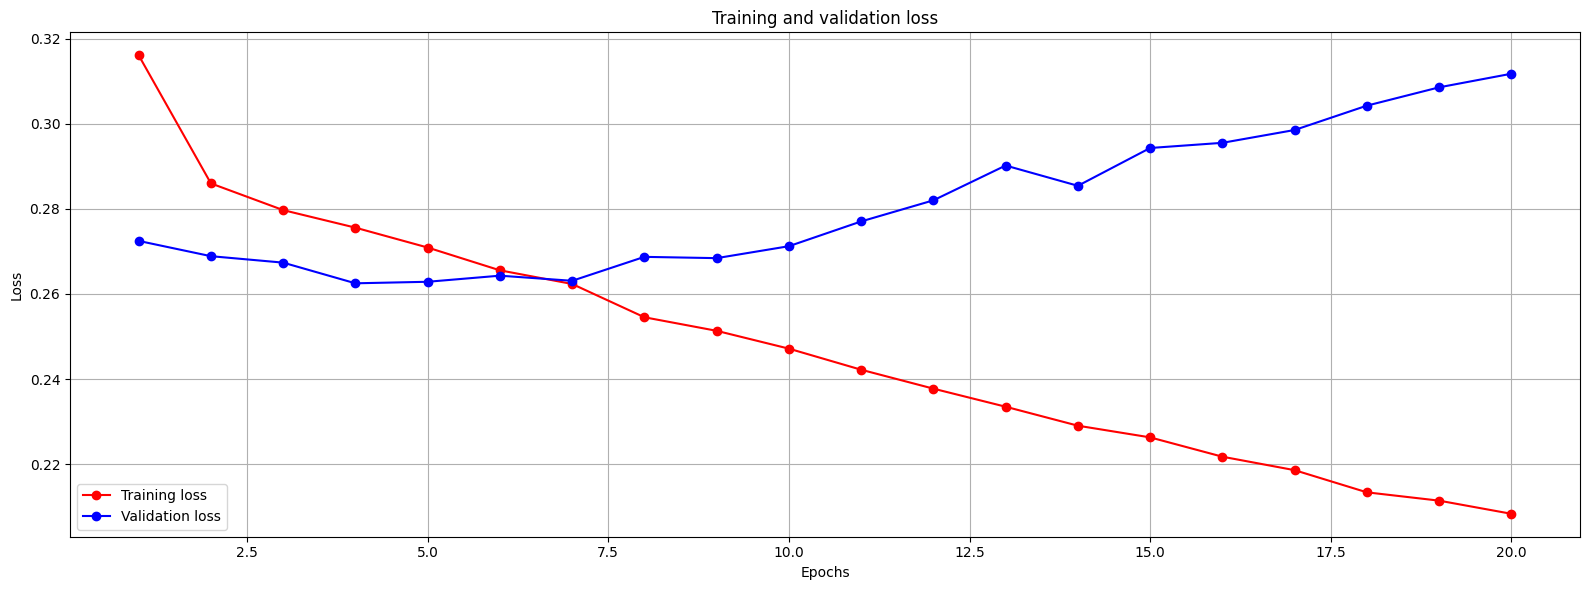

In [ ]:
# Plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 6))
plt.plot(epochs, loss, 'r-o', label='Training loss')
plt.plot(epochs, val_loss, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# GRU layer with dropout and recurrent_dropout

In [24]:
# Define the GRU model with dropout
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [25]:
# Train the GRU network with dropout for about 40 epochs
history = model.fit(train_gen,
                    #steps_per_epoch=(200000 - lookback) // batch_size,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 268ms/step - loss: 278959716318769577984.0000 - val_loss: 1.3133
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 268ms/step - loss: 270295617468452831232.0000 - val_loss: 1.3237
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 268ms/step - loss: 265338456100485201920.0000 - val_loss: 1.3278
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 267ms/step - loss: 259207772778052714496.0000 - val_loss: 1.3285
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 272ms/step - loss: 259756121217057161216.0000 - val_loss: 1.3298
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 270ms/step - loss: 268699759903619678208.0000 - val_loss: 1.3323
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 272ms/step - loss: 271768013071626272768.0000 - val_loss: 1.3281
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 270ms/step - loss: 265809293367777951744.0000 - val_loss: 1.3293
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 269ms/step - loss: 262273580632199135232.0000 - val_loss: 1.3277
Epoch 10/4

In [26]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                          │ (None, 32)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,284 (36.27 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,643 (18.14 KB)

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

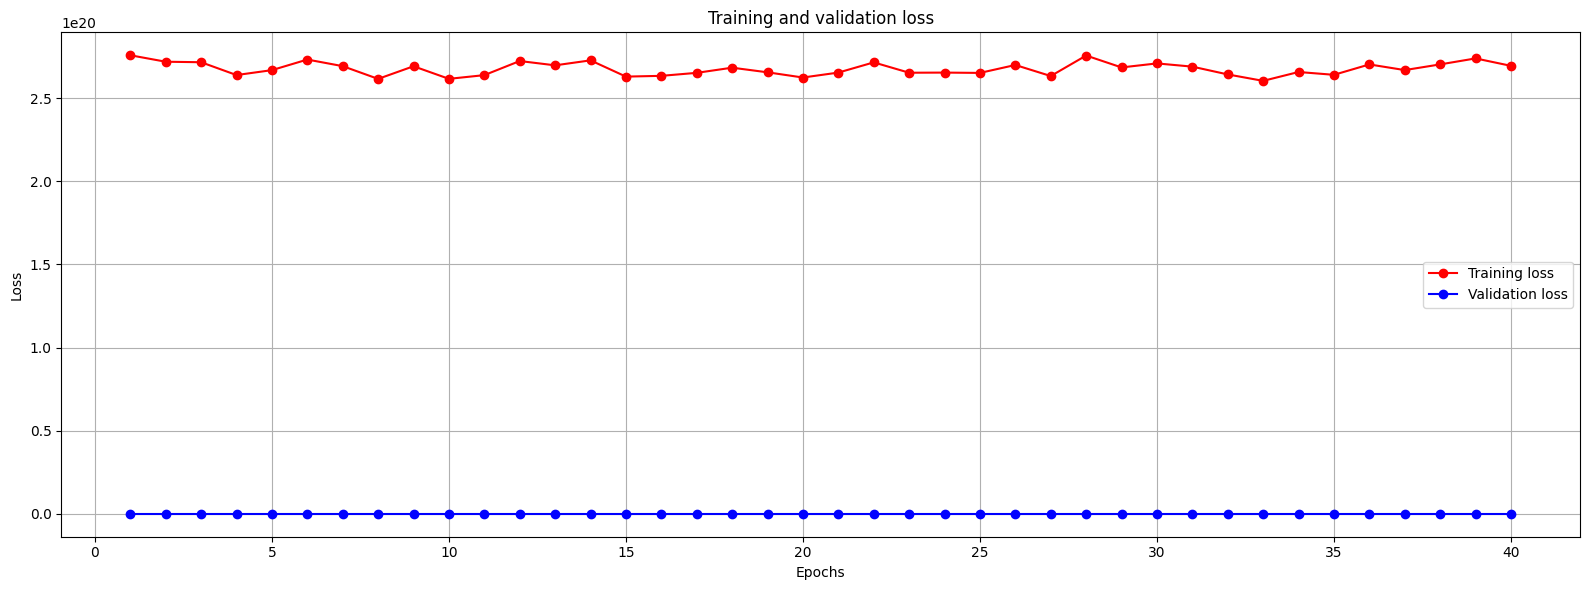

In [28]:
# Plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 6))
plt.plot(epochs, loss, 'r-o', label='Training loss')
plt.plot(epochs, val_loss, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Bidirectional GRU layer

In [ ]:
# Define the Bidirectional GRU model
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the Bidirectional GRU network for about 40 epochs
history = model.fit(train_gen,
                    #steps_per_epoch=(200000 - lookback) // batch_size,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.3321 - val_loss: 0.3293
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.3180 - val_loss: 0.3064
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.3116 - val_loss: 0.3272
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.3074 - val_loss: 0.3061
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.2993 - val_loss: 0.3179
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.2967 - val_loss: 0.3069
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2861 - val_loss: 0.3134
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.2838 - val_loss: 0.3308
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.2764 - val_loss: 0.3182
Epoch 10/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.2704 - val_loss: 0.3263
Epoch 11/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.2621 - val_loss: 0.3340
Epoch 12/40
500/500 ━━━━━━━━━━

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 64)                  │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,564 (72.52 KB)

 Trainable params: 9,281 (36.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,283 (36.27 KB)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

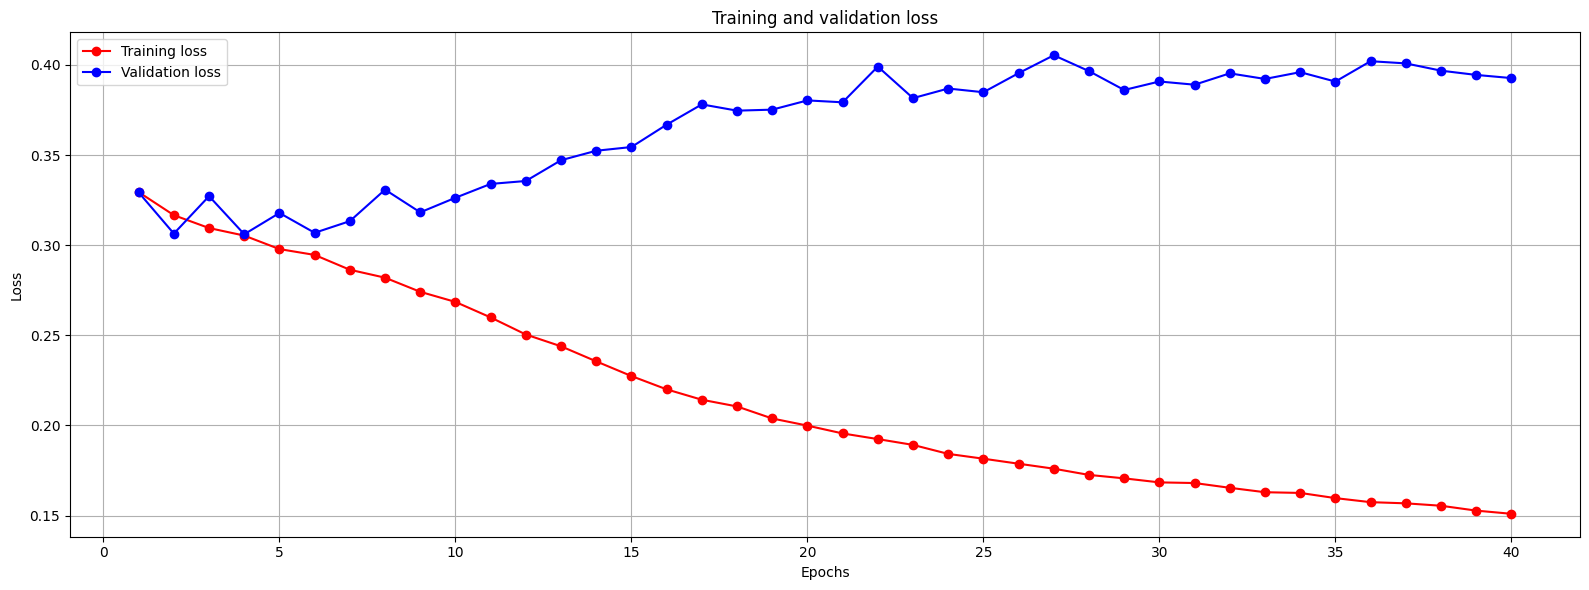

In [ ]:
# Plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 6))
plt.plot(epochs, loss, 'r-o', label='Training loss')
plt.plot(epochs, val_loss, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Conv1D Layers

In [11]:
# Define the Conv1D model
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.1))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [12]:
# Train the Conv1D network for about 20 epochs
history = model.fit(
      train_gen,
      steps_per_epoch=500,
      epochs=20,
      validation_data=val_gen,
      validation_steps=val_steps,
      batch_size=batch_size)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - loss: 0.4391 - val_loss: 0.3753
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - loss: 0.3676 - val_loss: 0.3515
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - loss: 0.3503 - val_loss: 0.3311
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - loss: 0.3422 - val_loss: 0.3289
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - loss: 0.3300 - val_loss: 0.3224
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - loss: 0.3223 - val_loss: 0.3410
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 155ms/step - loss: 0.3162 - val_loss: 0.3261
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - loss: 0.3083 - val_loss: 0.3290
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - loss: 0.3043 - val_loss: 0.3293
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - loss: 0.2967 - val_loss: 0.3350
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - loss: 0.2935 - val_loss: 0.3328
Epoch 12/20
500/500

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, None, 32)            │           2,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, None, 32)            │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,588 (107.77 KB)

 Trainable params: 13,793 (53.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,795 (53.89 KB)

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

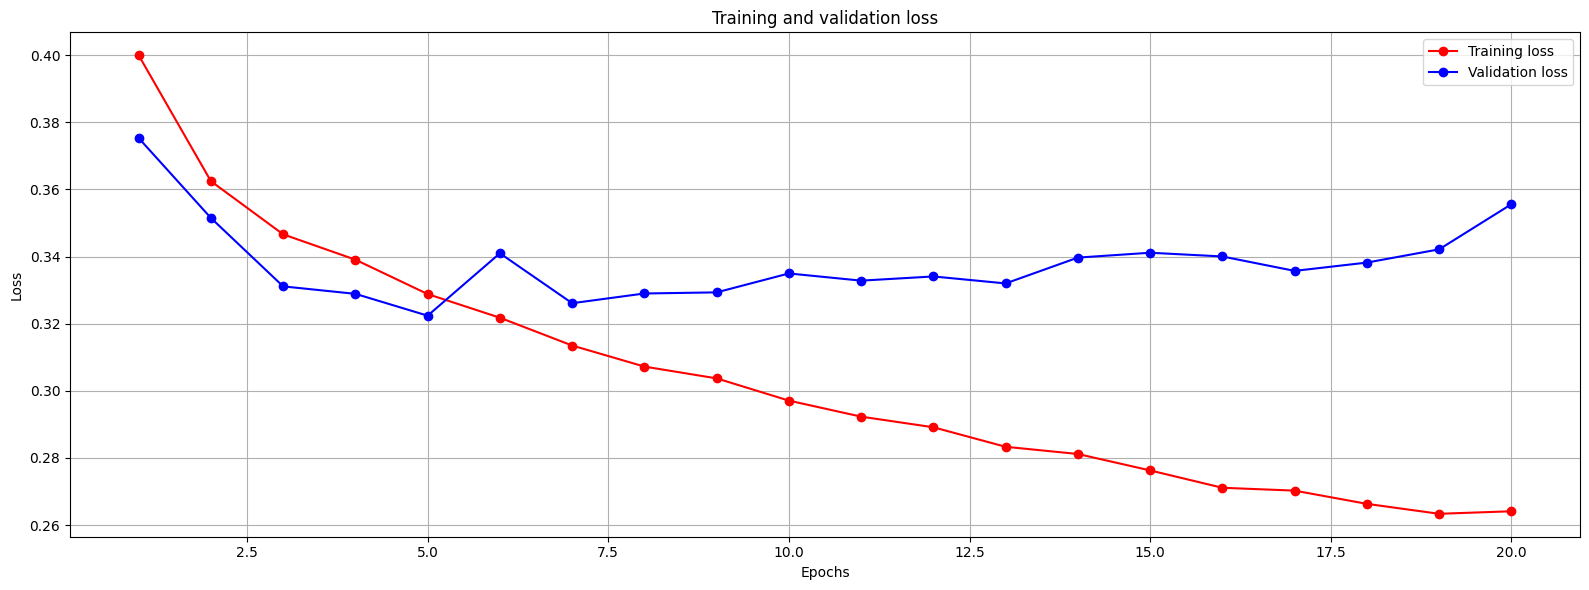

In [15]:
# Plot the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 6))
plt.plot(epochs, loss, 'r-o', label='Training loss')
plt.plot(epochs, val_loss, 'b-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()